# Library Load

In [120]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import math
import os
from lightgbm import LGBMRegressor
import lightgbm as lgb
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, timezone
from sklearn import preprocessing
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from scipy.stats import mstats

In [105]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Flatten, Dropout,Multiply,Add
from tensorflow.keras.models import load_model
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import *
import keras
from keras import losses
from keras import metrics

# Feature Engineering Code

In [40]:
### Feature engineering of Time variable
def feature_engineering(raw):
        
    #시간 변수 만들기
    raw['year'] = pd.DatetimeIndex(raw.index).year
    raw['month'] = pd.DatetimeIndex(raw.index).month
    raw['day'] = pd.DatetimeIndex(raw.index).day
    raw['hour'] = pd.DatetimeIndex(raw.index).hour
    raw['day_of_year'] = pd.DatetimeIndex(raw.index).dayofyear
    raw['week_of_year'] = pd.DatetimeIndex(raw.index).weekofyear
    raw['weekday'] = pd.DatetimeIndex(raw.index).weekday
    raw['season'] = raw.month%12 // 3 + 1
    raw['Quarter'] = pd.DatetimeIndex(raw.index).quarter
    raw['Quarter_ver2'] =(raw['Quarter'] + (raw.year - raw.year.min()) * 4)
    if 'Quarter' in raw.columns:
        if 'Quarter_Dummy' not in ['_'.join(col.split('_')[:2]) for col in raw.columns]:
            raw = pd.concat([raw, pd.get_dummies(raw['Quarter'], 
                                                 prefix='Quarter_Dummy', drop_first=True)], axis=1)
            del raw['Quarter']
    raw = pd.concat([raw, pd.get_dummies(raw['weekday']),pd.get_dummies(raw['year'])], axis=1)
    month_in_year = 12
    raw['month_sin'] = np.sin(2*np.pi*raw.month/month_in_year)
    raw['month_cos'] = np.cos(2*np.pi*raw.month/month_in_year)
    
    days_in_month = 30
    raw['day_sin'] = np.sin(2*np.pi*raw.day/days_in_month)
    raw['day_cos'] = np.cos(2*np.pi*raw.day/days_in_month)
    
    days_in_year = 365
    raw['day_of_year_sin'] = np.sin(2*np.pi*raw.day_of_year/days_in_year)
    raw['day_of_year_cos'] = np.cos(2*np.pi*raw.day_of_year/days_in_year)
    
    days = 24
    raw['Hour_sin'] = np.sin(2*np.pi*raw.hour/days)
    raw['Hour_cos'] = np.cos(2*np.pi*raw.hour/days)
    
    weeks_in_year = 52.1429
    raw['week_of_year_sin'] = np.sin(2*np.pi*raw.week_of_year/weeks_in_year)
    raw['week_of_year_cos'] = np.cos(2*np.pi*raw.week_of_year/weeks_in_year)
    
    seasons_in_year = 4
    raw['season_sin'] = np.sin(2*np.pi*raw.season/seasons_in_year)
    raw['season_cos'] = np.cos(2*np.pi*raw.season/seasons_in_year)
    raw.drop(['day', 'day_of_year', 'week_of_year', 'season','weekday'],axis=1,inplace=True)

    raw.drop(['month','hour','year'],axis=1,inplace=True)

    return raw

In [44]:
### Feature engineering for Test set
def feature_engineering_for_test(raw):
    #### two_sided를 False로하여 과거 데이터만 사용하게끔 함 ####
    #청담대교
    result = sm.tsa.seasonal_decompose(raw['청담대교수위'], model='additive',period=2, two_sided=False)
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['청담대교수위_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['청담대교수위_seasonal']
    pd.concat([raw, Y_trend, Y_seasonal], axis=1).isnull().sum()
    raw = pd.concat([raw, Y_trend, Y_seasonal], axis=1)
    #잠수교
    result = sm.tsa.seasonal_decompose(raw['잠수교수위'], model='additive',period=2, two_sided=False)
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['잠수교수위_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['잠수교수위_seasonal']
    pd.concat([raw, Y_trend, Y_seasonal], axis=1).isnull().sum()
    raw = pd.concat([raw, Y_trend, Y_seasonal], axis=1)
    #한강대교
    result = sm.tsa.seasonal_decompose(raw['한강대교수위'], model='additive',period=2, two_sided=False)
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['한강대교수위_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['한강대교수위_seasonal']
    pd.concat([raw, Y_trend, Y_seasonal], axis=1).isnull().sum()
    raw = pd.concat([raw, Y_trend, Y_seasonal], axis=1)
    
    #행주대교
    result = sm.tsa.seasonal_decompose(raw['행주대교수위'], model='additive',period=2, two_sided=False)
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['행주대교수위_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['행주대교수위_seasonal']
    pd.concat([raw, Y_trend, Y_seasonal], axis=1).isnull().sum()
    raw = pd.concat([raw, Y_trend, Y_seasonal], axis=1)


    # STL분해 중 잔차 구하기-청담대교
    result = sm.tsa.seasonal_decompose(raw['청담대교수위'], model='additive',period=2,two_sided=False)
    Y_remainder = pd.DataFrame(result.resid)
    Y_remainder.fillna(method='ffill', inplace=True)
    Y_remainder.fillna(method='bfill', inplace=True)
    Y_remainder.columns = ['청담대교수위_resid']
    raw = pd.concat([raw, Y_remainder], axis=1)

    # STL분해 중 잔차 구하기-잠수교
    result = sm.tsa.seasonal_decompose(raw['잠수교수위'], model='additive',period=2,two_sided=False)
    Y_remainder = pd.DataFrame(result.resid)
    Y_remainder.fillna(method='ffill', inplace=True)
    Y_remainder.fillna(method='bfill', inplace=True)
    Y_remainder.columns = ['잠수교수위_resid']
    raw = pd.concat([raw, Y_remainder], axis=1)

    # STL분해 중 잔차 구하기-한강대교
    result = sm.tsa.seasonal_decompose(raw['한강대교수위'], model='additive',period=2,two_sided=False)
    Y_remainder = pd.DataFrame(result.resid)
    Y_remainder.fillna(method='ffill', inplace=True)
    Y_remainder.fillna(method='bfill', inplace=True)
    Y_remainder.columns = ['한강대교수위_resid']
    raw = pd.concat([raw, Y_remainder], axis=1)
    
    # STL분해 중 잔차 구하기-행주대교
    result = sm.tsa.seasonal_decompose(raw['행주대교수위'], model='additive',period=2,two_sided=False)
    Y_remainder = pd.DataFrame(result.resid)
    Y_remainder.fillna(method='ffill', inplace=True)
    Y_remainder.fillna(method='bfill', inplace=True)
    Y_remainder.columns = ['행주대교수위_resid']
    raw = pd.concat([raw, Y_remainder], axis=1)
    
    #시간 변수 만들기
    raw['year'] = pd.DatetimeIndex(raw.index).year
    raw['month'] = pd.DatetimeIndex(raw.index).month
    raw['day'] = pd.DatetimeIndex(raw.index).day
    raw['hour'] = pd.DatetimeIndex(raw.index).hour
    raw['day_of_year'] = pd.DatetimeIndex(raw.index).dayofyear
    raw['week_of_year'] = pd.DatetimeIndex(raw.index).weekofyear
    raw['weekday'] = pd.DatetimeIndex(raw.index).weekday
    raw['season'] = raw.month%12 // 3 + 1
    raw['Quarter'] = pd.DatetimeIndex(raw.index).quarter
    raw['Quarter_ver2'] =(raw['Quarter'] + (raw.year - raw.year.min()) * 4)
    if 'Quarter' in raw.columns:
        if 'Quarter_Dummy' not in ['_'.join(col.split('_')[:2]) for col in raw.columns]:
            raw = pd.concat([raw, pd.get_dummies(raw['Quarter'], 
                                                 prefix='Quarter_Dummy', drop_first=True)], axis=1)
            del raw['Quarter']
    raw = pd.concat([raw, pd.get_dummies(raw['weekday']),pd.get_dummies(raw['year'])], axis=1)
    month_in_year = 12
    raw['month_sin'] = np.sin(2*np.pi*raw.month/month_in_year)
    raw['month_cos'] = np.cos(2*np.pi*raw.month/month_in_year)
    
    days_in_month = 30
    raw['day_sin'] = np.sin(2*np.pi*raw.day/days_in_month)
    raw['day_cos'] = np.cos(2*np.pi*raw.day/days_in_month)
    
    days_in_year = 365
    raw['day_of_year_sin'] = np.sin(2*np.pi*raw.day_of_year/days_in_year)
    raw['day_of_year_cos'] = np.cos(2*np.pi*raw.day_of_year/days_in_year)
    
    days = 24
    raw['Hour_sin'] = np.sin(2*np.pi*raw.hour/days)
    raw['Hour_cos'] = np.cos(2*np.pi*raw.hour/days)
    
    weeks_in_year = 52.1429
    raw['week_of_year_sin'] = np.sin(2*np.pi*raw.week_of_year/weeks_in_year)
    raw['week_of_year_cos'] = np.cos(2*np.pi*raw.week_of_year/weeks_in_year)
    
    seasons_in_year = 4
    raw['season_sin'] = np.sin(2*np.pi*raw.season/seasons_in_year)
    raw['season_cos'] = np.cos(2*np.pi*raw.season/seasons_in_year)
    raw.drop(['day', 'day_of_year', 'week_of_year', 'season','weekday'],axis=1,inplace=True)
    
    for a in range(6,7):
        raw[f'청담대교수위_lag{a}'] = raw['청담대교수위'].shift(a)
        raw[f'청담대교수위_lag{a}'].fillna(method='bfill',inplace=True)
        raw[f'잠수교수위_lag{a}'] = raw['잠수교수위'].shift(a)
        raw[f'잠수교수위_lag{a}'].fillna(method='bfill',inplace=True)
        raw[f'한강대교수위_lag{a}'] = raw['한강대교수위'].shift(a)
        raw[f'한강대교수위_lag{a}'].fillna(method='bfill',inplace=True)
        raw[f'행주대교수위_lag{a}'] = raw['행주대교수위'].shift(a)
        raw[f'행주대교수위_lag{a}'].fillna(method='bfill',inplace=True)
    for a in range(12,13):
        raw[f'청담대교수위_lag{a}'] = raw['청담대교수위'].shift(a)
        raw[f'청담대교수위_lag{a}'].fillna(method='bfill',inplace=True)
        raw[f'잠수교수위_lag{a}'] = raw['잠수교수위'].shift(a)
        raw[f'잠수교수위_lag{a}'].fillna(method='bfill',inplace=True)
        raw[f'한강대교수위_lag{a}'] = raw['한강대교수위'].shift(a)
        raw[f'한강대교수위_lag{a}'].fillna(method='bfill',inplace=True)
        raw[f'행주대교수위_lag{a}'] = raw['행주대교수위'].shift(a)
        raw[f'행주대교수위_lag{a}'].fillna(method='bfill',inplace=True)
        

    raw.drop(['month','hour','year'],axis=1,inplace=True)

    return raw

# Raw Data Load

In [3]:
def read_csv_by_dir(path, index_col=None):
    df_raw = pd.DataFrame()
    for files in os.listdir(path):
        if files.endswith('.csv'):
            df = pd.read_csv('/'.join([path,files]),
                            index_col=index_col,encoding='cp949')
        df_raw = pd.concat((df_raw,df),axis=0)
    return df_raw

def index_to_datetime(df,format):
    df.index = pd.to_datetime(df.index,
                              format=format)
    return df

In [7]:
path = './competition_data'
_df_rf_raw = read_csv_by_dir('/'.join([path,'rf_data']),
                            index_col=0)

_df_water_raw = read_csv_by_dir('/'.join([path,'water_data']),
                               index_col=0)

df_rf=_df_rf_raw.copy()
df_rf.name = "rain_data"

df_water=_df_water_raw.copy()
df_water.name = "water_data"

df_rf=index_to_datetime(df=df_rf,format='%Y-%m-%d %H:%M')
df_water=index_to_datetime(df=df_water,format='%Y-%m-%d %H:%M')

df_rf.columns = ['대곡교강수량','진관교강수량','송정동강수량']
df_water.columns = ['팔당댐현재수위','팔당댐유입량','팔당댐저수량','팔당댐공용량'\
               ,'총방류량','강화대교조위','청담대교수위','청담대교유량','잠수교수위','잠수교유량','한강대교수위',\
                    '한강대교유량','행주대교수위','행주대교유량']
null_idx= _df_water_raw[_df_water_raw['tide_level'].isna()==True].index

# Tide Level fill NaN

In [8]:
tide = pd.read_csv('./강화대교조위.csv')

tide.set_index('record_time',inplace=True)

tide=index_to_datetime(df=tide,format='%Y-%m-%d %H:%M')

In [13]:
null = pd.DataFrame(np.NaN,columns=['tide_level'],index=null_idx)

concat = pd.concat([tide,null],axis=0)

concat.reset_index(drop=False,inplace=True)

concat = concat.drop_duplicates(subset='index',keep='first')

concat.set_index('index',inplace=True)

concat = concat.sort_index(ascending=True)

concat.reset_index(drop=False,inplace=True)

C:\Users\user\AppData\Local\Temp/ipykernel_18520/2785564917.py:5: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
  concat.reset_index(drop=False,inplace=True)


In [14]:
for i in tqdm(range(0,len(concat))):
    if concat['index'][i].second !=0:
        concat['index'][i] = concat['index'][i] - timedelta(seconds=concat['index'][i].second)
    else:
        pass

  0%|                                                                                       | 0/520602 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp/ipykernel_18520/3267482343.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  concat['index'][i] = concat['index'][i] - timedelta(seconds=concat['index'][i].second)
100%|████████████████████████████████████████████████████████████████████████| 520602/520602 [01:56<00:00, 4475.53it/s]


In [15]:
null = concat[concat['tide_level'].isna()==True]['index']

## 같은 시간대 다른 연도 조위 가져와서 결측치 채우기

In [17]:
null.reset_index(drop=True,inplace=True)

concat.set_index('index',inplace=True)

train= concat[concat.index <= '2022-5-31 23:40:00']
test = concat[concat.index > '2022-5-31 23:40:00']

train_null = train[train['tide_level'].isna()==True]

for i in tqdm(range(0,len(train_null))):
    tide = train['tide_level'][(train_null.index[i].month == train.index.month.values) & \
            (train_null.index[i].day  == train.index.day.values) & \
            (train_null.index[i].hour == train.index.hour.values) & \
            (train_null.index[i].minute == train.index.minute.values)]
    concat.loc[train_null.index[i]]  =  tide.mean()     

100%|██████████████████████████████████████████████████████████████████████████████| 3126/3126 [05:30<00:00,  9.46it/s]


## 남은 거 채우기

In [18]:
null = concat[concat['tide_level'].isna()==True].index

train= concat[concat.index <= '2022-5-31 23:40:00']
test = concat[concat.index > '2022-5-31 23:40:00']

train_null = train[train['tide_level'].isna()==True]

for i in tqdm(range(0,len(train_null))):
    tide = train['tide_level'][(train_null.index[i].month == train.index.month.values) & \
            (train_null.index[i].day  == train.index.day.values) & \
            (train_null.index[i].hour == train.index.hour.values)]
    concat.loc[train_null.index[i]]  =  tide.mean()     

100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [00:16<00:00, 12.44it/s]


## 남은 거 채우기

In [19]:
null = concat[concat['tide_level'].isna()==True].index

train= concat[concat.index <= '2022-5-31 23:40:00']
test = concat[concat.index > '2022-5-31 23:40:00']

train_null = train[train['tide_level'].isna()==True]

train.interpolate(method='values',inplace=True)

concat['tide_level'].loc[train_null.index] = train['tide_level'].loc[train_null.index].values

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:10712: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().interpolate(


## 남은거 채우기

In [20]:
null = concat[concat['tide_level'].isna()==True].index

train= concat[concat.index <= '2022-5-31 23:40:00']
test = concat[concat.index > '2022-5-31 23:40:00']

# Test데이터는 직전 값으로 채우기
test.fillna(method='ffill',inplace=True)

concat['tide_level'].loc[null] = test['tide_level'].loc[null].values

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


# 결측값 넣기

In [26]:
null_idx = df_water[df_water['강화대교조위'].isna()==True].index

df_water['강화대교조위'].loc[null_idx] = concat['tide_level'].loc[null_idx].values

# 날씨관련 변수 넣기

In [30]:
additional = pd.read_csv('8월29일만든파생변수.csv',engine='python',encoding='utf-8')
additional.set_index('ymdhm',inplace=True)
additional = index_to_datetime(df=additional,format='%Y-%m-%d %H:%M')
additional = additional.loc[~additional.index.duplicated(keep='first')]

concat = pd.concat([df_rf,df_water],axis=1)
absent = pd.concat([concat,additional],axis=1)
absent = feature_engineering(absent)

train= absent[absent.index <= '2022-5-31 23:50:00']
Test = absent[absent.index > '2022-5-31 23:50:00']

C:\Users\user\AppData\Local\Temp/ipykernel_18520/1964517571.py:10: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  raw['week_of_year'] = pd.DatetimeIndex(raw.index).weekofyear


# Train Data 선형보간

In [31]:
train.interpolate(method='linear',limit=100,limit_direction='both',limit_area=None,inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:10712: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().interpolate(


In [32]:
train.drop(['잠수교유량'],axis=1,inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


# Train data 청담대교 유량 채우기

In [33]:
# 휴리스틱하게 정한 파라미터
params = {'colsample_bytree': 0.8,
         'max_depth': 13,
         'min_data_in_leaf': 500,
         'num_iteration': 20000,
         'num_leaves': 2300,
         'objective': 'regression',
         'metric': 'rmse',
         'learning_rate': 0.05,
         'random_state': 1992,
         'boosting_type': 'gbdt',
         'verbose': -1}

In [34]:
#청담대교유량 채우기
train_set = train[train['청담대교유량'].isna()==False]
test_set = train[train['청담대교유량'].isna()==True]

x_train = train_set.drop(['청담대교유량'],axis=1)
y_train = train_set.청담대교유량
x_test= test_set.drop(['청담대교유량'],axis=1)
y_test = test_set.청담대교유량

lgb = LGBMRegressor(**params)
lgb.fit(x_train,y_train)
result = lgb.predict(x_test)

train['청담대교유량'][train['청담대교유량'].isna()==True]=result

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] num_iterations is set=20000, num_iteration=20000 will be ignored. Current value: num_iterations=20000


C:\Users\user\AppData\Local\Temp/ipykernel_18520/660064360.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['청담대교유량'][train['청담대교유량'].isna()==True]=result
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


# Test set 결측치 처리

In [37]:
train = train[['대곡교강수량',           '진관교강수량',           '송정동강수량',
                '팔당댐현재수위',           '팔당댐유입량',           '팔당댐저수량',
                 '팔당댐공용량',             '총방류량',           '강화대교조위',
                 '청담대교수위',           '청담대교유량',            '잠수교수위',
                            '한강대교수위',           '한강대교유량',
                 '행주대교수위',           '행주대교유량',               '기온',
                     '일사',               '일조',              '증발량',
                 '중랑천_수위',           '중랑천_유량',            '탄천_수위',
                  '탄천_유량',           '안양천_수위',           '안양천_유량']]
Test = Test[['대곡교강수량',           '진관교강수량',           '송정동강수량',
                '팔당댐현재수위',           '팔당댐유입량',           '팔당댐저수량',
                 '팔당댐공용량',             '총방류량',           '강화대교조위',
                 '청담대교수위',           '청담대교유량',            '잠수교수위',
                             '한강대교수위',           '한강대교유량',
                 '행주대교수위',           '행주대교유량',               '기온',
                     '일사',               '일조',              '증발량',
                 '중랑천_수위',           '중랑천_유량',            '탄천_수위',
                  '탄천_유량',           '안양천_수위',           '안양천_유량']]

In [45]:
wan = pd.concat([train,Test],axis=0)

wan = feature_engineering_for_test(wan)

C:\Users\user\AppData\Local\Temp/ipykernel_18520/102255047.py:93: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  raw['week_of_year'] = pd.DatetimeIndex(raw.index).weekofyear


In [47]:
wan_copy = wan.copy()

wan[wan['팔당댐현재수위'].isna()==True]

,대곡교강수량,진관교강수량,송정동강수량,팔당댐현재수위,팔당댐유입량,팔당댐저수량,팔당댐공용량,총방류량,강화대교조위,청담대교수위,...,season_sin,season_cos,청담대교수위_lag6,잠수교수위_lag6,한강대교수위_lag6,행주대교수위_lag6,청담대교수위_lag12,잠수교수위_lag12,한강대교수위_lag12,행주대교수위_lag12
ymdhm,,,,,,,,,,,,,,,,,,,,,
2022-06-08 12:30:00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,514.0,0.0,...,-1.0,-1.836970e-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-06-08 12:40:00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,506.0,0.0,...,-1.0,-1.836970e-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-06-08 12:50:00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,497.0,0.0,...,-1.0,-1.836970e-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-06-08 13:00:00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,487.0,0.0,...,-1.0,-1.836970e-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-06-08 13:10:00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,477.0,0.0,...,-1.0,-1.836970e-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-06-08 13:20:00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,466.0,0.0,...,-1.0,-1.836970e-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-06-08 13:30:00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,456.0,0.0,...,-1.0,-1.836970e-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-06-08 13:40:00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,446.0,0.0,...,-1.0,-1.836970e-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-06-08 13:50:00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,435.0,0.0,...,-1.0,-1.836970e-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 팔당댐 유입량 채우기

In [48]:
# 미래시점으로 바꿔주기
wan_copy['팔당댐유입량'] = wan_copy['팔당댐유입량'].shift(-1)
wan_copy[wan_copy['팔당댐유입량'].isna()==True]

train= wan_copy[wan_copy.index < '2022-06-08 12:20:00']
test = wan_copy[wan_copy.index >= '2022-06-08 12:20:00']
test = test[test['팔당댐유입량'].isna()==True]

y_train = train[['팔당댐유입량']]
x_train = train.drop(['팔당댐현재수위','팔당댐유입량','팔당댐저수량','팔당댐공용량','총방류량'],axis=1)

y_test = test[['팔당댐유입량']]
x_test = test.drop(['팔당댐현재수위','팔당댐유입량','팔당댐저수량','팔당댐공용량','총방류량'],axis=1)

lgb = LGBMRegressor(**params)
lgb.fit(x_train,y_train)
result = lgb.predict(x_test)

real = wan[wan['팔당댐유입량'].isna()==True]
result = result[:-1]
plf = pd.Series(result.flatten(),index=real.index)

wan['팔당댐유입량'].fillna(plf,inplace=True)

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] num_iterations is set=20000, num_iteration=20000 will be ignored. Current value: num_iterations=20000


# 팔당댐 현재수위 채우기

In [49]:
# 미래시점으로 바꿔주기
wan_copy = wan.copy()
wan_copy['팔당댐현재수위'] = wan_copy['팔당댐현재수위'].shift(-1)

train= wan_copy[wan_copy.index < '2022-06-08 12:20:00']
test = wan_copy[wan_copy.index >= '2022-06-08 12:20:00']
test = test[test['팔당댐현재수위'].isna()==True]

y_train = train[['팔당댐현재수위']]
x_train = train.drop(['팔당댐현재수위','팔당댐유입량','팔당댐저수량','팔당댐공용량','총방류량'],axis=1)

y_test = test[['팔당댐현재수위']]
x_test = test.drop(['팔당댐현재수위','팔당댐유입량','팔당댐저수량','팔당댐공용량','총방류량'],axis=1)

lgb = LGBMRegressor(**params)
lgb.fit(x_train,y_train)
result = lgb.predict(x_test)

real = wan[wan['팔당댐현재수위'].isna()==True]
result = result[:-1]
plf = pd.Series(result.flatten(),index=real.index)

wan['팔당댐현재수위'].fillna(plf,inplace=True)

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] num_iterations is set=20000, num_iteration=20000 will be ignored. Current value: num_iterations=20000


# 팔당댐 저수량 채우기

In [50]:
# 미래시점으로 바꿔주기
wan_copy = wan.copy()
wan_copy['팔당댐저수량'] = wan_copy['팔당댐저수량'].shift(-1)

train= wan_copy[wan_copy.index < '2022-06-08 12:20:00']
test = wan_copy[wan_copy.index >= '2022-06-08 12:20:00']
test = test[test['팔당댐저수량'].isna()==True]

y_train = train[['팔당댐저수량']]
x_train = train.drop(['팔당댐현재수위','팔당댐유입량','팔당댐저수량','팔당댐공용량','총방류량'],axis=1)

y_test = test[['팔당댐저수량']]
x_test = test.drop(['팔당댐현재수위','팔당댐유입량','팔당댐저수량','팔당댐공용량','총방류량'],axis=1)

lgb = LGBMRegressor(**params)
lgb.fit(x_train,y_train)
result = lgb.predict(x_test)

real = wan[wan['팔당댐저수량'].isna()==True]
result = result[:-1]
plf = pd.Series(result.flatten(),index=real.index)
wan['팔당댐저수량'].fillna(plf,inplace=True)

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] num_iterations is set=20000, num_iteration=20000 will be ignored. Current value: num_iterations=20000


# 팔당댐 공용량 채우기

In [51]:
wan_copy = wan.copy()
# 미래시점으로 바꿔주기
wan_copy['팔당댐공용량'] = wan_copy['팔당댐공용량'].shift(-1)

train= wan_copy[wan_copy.index < '2022-06-08 12:20:00']
test = wan_copy[wan_copy.index >= '2022-06-08 12:20:00']
test = test[test['팔당댐공용량'].isna()==True]

y_train = train[['팔당댐공용량']]
x_train = train.drop(['팔당댐현재수위','팔당댐유입량','팔당댐저수량','팔당댐공용량','총방류량'],axis=1)

y_test = test[['팔당댐공용량']]
x_test = test.drop(['팔당댐현재수위','팔당댐유입량','팔당댐저수량','팔당댐공용량','총방류량'],axis=1)

lgb = LGBMRegressor(**params)
lgb.fit(x_train,y_train)
result = lgb.predict(x_test)

real = wan[wan['팔당댐공용량'].isna()==True]
result = result[:-1]
plf = pd.Series(result.flatten(),index=real.index)

wan['팔당댐공용량'].fillna(plf,inplace=True)

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] num_iterations is set=20000, num_iteration=20000 will be ignored. Current value: num_iterations=20000


# 팔당댐 총방류량 채우기

In [52]:
wan_copy = wan.copy()
# 미래시점으로 바꿔주기
wan_copy['총방류량'] = wan_copy['총방류량'].shift(-1)

train= wan_copy[wan_copy.index < '2022-06-08 12:20:00']
test = wan_copy[wan_copy.index >= '2022-06-08 12:20:00']
test = test[test['총방류량'].isna()==True]

y_train = train[['총방류량']]
x_train = train.drop(['팔당댐현재수위','팔당댐유입량','팔당댐저수량','팔당댐공용량','총방류량'],axis=1)

y_test = test[['총방류량']]
x_test = test.drop(['팔당댐현재수위','팔당댐유입량','팔당댐저수량','팔당댐공용량','총방류량'],axis=1)

lgb = LGBMRegressor(**params)
lgb.fit(x_train,y_train)
result = lgb.predict(x_test)

real = wan[wan['총방류량'].isna()==True]
result = result[:-1]
plf = pd.Series(result.flatten(),index=real.index)

wan['총방류량'].fillna(plf,inplace=True)

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] num_iterations is set=20000, num_iteration=20000 will be ignored. Current value: num_iterations=20000


# 청담대교 유량 채우기

In [53]:
wan_copy = wan.copy()
#미래시점으로 바꿔주기
wan_copy['청담대교유량'] = wan_copy['청담대교유량'].shift(-1)
train= wan_copy[wan_copy.index < '2022-06-01 04:00:00']
test = wan_copy[wan_copy.index >= '2022-06-01 04:00:00']
test = test[test['청담대교유량'].isna()==True]

y_train = train[['청담대교유량']]
x_train = train.drop(['청담대교유량'],axis=1)

y_test = test[['청담대교유량']]
x_test = test.drop(['청담대교유량'],axis=1)

lgb = LGBMRegressor(**params)
lgb.fit(x_train,y_train)
result = lgb.predict(x_test)

real = wan[wan['청담대교유량'].isna()==True]
result = result[:-1]
plf = pd.Series(result.flatten(),index=real.index)

wan['청담대교유량'].fillna(plf,inplace=True)

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] num_iterations is set=20000, num_iteration=20000 will be ignored. Current value: num_iterations=20000


# 한강대교 유량 -값 없애기

In [60]:
# 한강홍수통제소에서 다운받은 대교별 10분전 수위파일
Target= pd.read_csv('Target.csv',encoding='ISO-8859-1')

check = Target.iloc[-6912:].values

wan.iloc[-6912:,[9,11,12,14]] = check

In [65]:
gum = wan[wan['한강대교유량']<0]['한강대교유량'].index
wan['한강대교수위_수위'] = (wan['한강대교수위']-207)/100
wan['강화대교수위'] = (wan['강화대교조위']-14)/100

In [63]:
wan['만조간조']=0  #1:만조,0:간조
wan['만조간조'][0:3] = 1
for i in tqdm(range(0,7676)):
    if i%2==0:
        wan['만조간조'][(i)*36+4:(i+1)*36+4]=0
    else:
        wan['만조간조'][(i)*36+4:(i+1)*36+4]=1

C:\Users\user\AppData\Local\Temp/ipykernel_18520/2462783329.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wan['만조간조'][0:3] = 1
  0%|                                                                                         | 0/7676 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp/ipykernel_18520/2462783329.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wan['만조간조'][(i)*36+4:(i+1)*36+4]=0
C:\Users\user\AppData\Local\Temp/ipykernel_18520/2462783329.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/panda

In [66]:
수위 = wan['한강대교수위_수위']
강화수위 = wan['강화대교수위']
ganjo=[]
manjo3up=[]
manjo3do=[]
for i in tqdm(range(0,len(wan)-1)):
    if wan['한강대교유량'][i]< 0:
        if 강화수위[i-12]<0:
            if wan['만조간조'][i]==1 and wan['강화대교조위'][i]>=300:
                manjo3up.append(i)
                wan['한강대교유량'][i] = 360.23*math.pow((float(수위[i])+0.5) , 3.7133)\
                                            *math.pow((abs(강화수위[i-12])+float(수위[i])+0.5), -0.0005)\
                                            *math.pow(((수위[i])-float(수위[i-3])+0.5), 1.7013)
            elif wan['만조간조'][i]==1 and wan['강화대교조위'][i]<300:
                manjo3do.append(i)
                wan['한강대교유량'][i] = 1074.40*math.pow((float(수위[i])+0.5),5.1148)\
                                                *math.pow(((abs(강화수위[i-12])+abs(수위[i]))+0.5) , 0.1732)\
                                                *math.pow((float(수위[i])-float(수위[i-3])+0.5), 3.9886)
            elif wan['만조간조'][i]==0: #간조
                ganjo.append(i)
                wan['한강대교유량'][i] = 10108.96*math.pow((float(수위[i])+1.4) ,-0.2240)\
                                            *math.pow((float(수위[i])+abs(강화수위[i-12])+1.4), 0.1428)\
                                        *math.pow((float(수위[i-3])-float(수위[i])+1.4), -3.1277) -3000
        else:
            if wan['만조간조'][i]==1 and wan['강화대교조위'][i]>=300: # 만조 % 수위>3m
                manjo3up.append(i)
                wan['한강대교유량'][i] = 360.23*math.pow((float(수위[i])+0.5) , 3.7133)\
                                            *math.pow(abs(float(강화수위[i-12])-float(수위[i]))+0.5, -0.0005)\
                                            *math.pow((수위[i])-float(수위[i-3])+0.5, 1.7013)

            elif wan['만조간조'][i]==1 and wan['강화대교조위'][i]<300: # 만조 & 수위<3m
                manjo3do.append(i)
                wan['한강대교유량'][i] = 1074.40*math.pow((float(수위[i])+0.5),5.1148)\
                                                *math.pow((abs(float(강화수위[i-12])-float(수위[i]))+0.5) , 0.1732)\
                                                *math.pow((수위[i]-수위[i-3])+0.5, 3.9886)
            elif wan['만조간조'][i]==0: #간조
                ganjo.append(i)  
                wan['한강대교유량'][i] = 10108.96*math.pow((float(수위[i])+1.4) ,-0.2240)\
                                                *math.pow(abs(float(수위[i])-float(강화수위[i-12]))+1.4, 0.1428)\
                                            *math.pow((float(수위[i-3])-float(수위[i])+1.4), -3.1277)-3000            
    else:
        pass

  0%|                                                                                       | 0/276335 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp/ipykernel_18520/484158827.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wan['한강대교유량'][i] = 10108.96*math.pow((float(수위[i])+1.4) ,-0.2240)\
C:\Users\user\AppData\Local\Temp/ipykernel_18520/484158827.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wan['한강대교유량'][i] = 360.23*math.pow((float(수위[i])+0.5) , 3.7133)\
C:\Users\user\AppData\Local\Temp/ipykernel_18520/484158827.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [68]:
wan['만조3up'] = 0
wan['만조3down']=0
wan['간조']=0
for i in tqdm(range(0,len(wan))):
    if wan['만조간조'][i]==1 and wan['강화대교조위'][i]>300:
        wan['만조3up'][i] = 1
    elif wan['만조간조'][i]==1 and wan['강화대교조위'][i]<=300:
        wan['만조3down'][i]=1
    elif wan['만조간조'][i]==0:
        wan['간조'][i]=1
wan.drop(['만조간조','한강대교수위_수위','강화대교수위'],axis=1,inplace=True)

  0%|                                                                                       | 0/276336 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp/ipykernel_18520/322477472.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wan['만조3up'][i] = 1
C:\Users\user\AppData\Local\Temp/ipykernel_18520/322477472.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wan['간조'][i]=1
C:\Users\user\AppData\Local\Temp/ipykernel_18520/322477472.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

# 팔당댐 방류량 변수 만들기

In [69]:
wan['누적방류량(10h)']=0
wan['누적방류량(15h)']=0
wan['누적방류량(20h)']=0
wan['누적방류량(25h)']=0
wan['누적방류량(30h)']=0
wan['방류량증가(10h)']=0
wan['방류량증가(15h)']=0
wan['방류량증가(20h)']=0
wan['방류량증가(25h)']=0
wan['방류량증가(30h)']=0
for i in tqdm(range(60,len(wan)-1)):
    wan['누적방류량(10h)'][i] = wan['총방류량'][i-60:i].sum()
    wan['누적방류량(15h)'][i] = wan['총방류량'][i-90:i].sum() 
    wan['누적방류량(20h)'][i] = wan['총방류량'][i-120:i].sum() 
    wan['누적방류량(25h)'][i] = wan['총방류량'][i-150:i].sum() 
    wan['누적방류량(30h)'][i] = wan['총방류량'][i-180:i].sum()
    if wan['누적방류량(10h)'][i-1]<wan['누적방류량(10h)'][i]:
        wan['방류량증가(10h)'][i] = 1
    if wan['누적방류량(15h)'][i-1]<wan['누적방류량(15h)'][i]:
        wan['방류량증가(15h)'][i] = 1
    if wan['누적방류량(20h)'][i-1]<wan['누적방류량(20h)'][i]:
        wan['방류량증가(20h)'][i] = 1
    if wan['누적방류량(25h)'][i-1]<wan['누적방류량(25h)'][i]:
        wan['방류량증가(25h)'][i] = 1
    if wan['누적방류량(30h)'][i-1]<wan['누적방류량(30h)'][i]:
        wan['방류량증가(30h)'][i] = 1

  0%|                                                                                       | 0/276275 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp/ipykernel_18520/449681002.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wan['누적방류량(10h)'][i] = wan['총방류량'][i-60:i].sum()
C:\Users\user\AppData\Local\Temp/ipykernel_18520/449681002.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wan['누적방류량(15h)'][i] = wan['총방류량'][i-90:i].sum()
C:\Users\user\AppData\Local\Temp/ipykernel_18520/449681002.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docu

In [72]:
wan['누적방류량(1h)']=0
wan['잠수교_보행자통제']=0
wan['잠수교_차량통제']=0
wan['잠수교_완전통제']=0
wan['잠수교_보행자통제count']=0
wan['잠수교_차량통제count']=0
wan['잠수교_완전통제count']=0
for i in tqdm(range(6,len(wan)-1)):
    wan['누적방류량(1h)'][i] = wan['총방류량'][i-6:i].sum()
    try:
        wan['잠수교_보행자통제'][i] = 405.39*math.pow(wan['누적방류량(1h)'][i],-0.6215)
        wan['잠수교_차량통제'][i] = 561.5*math.pow(wan['누적방류량(1h)'][i],-0.6252)
        wan['잠수교_완전통제'][i] = 624.68*math.pow(wan['누적방류량(1h)'][i],-0.6278)
        
        ts = wan['잠수교_보행자통제'][i] 
        wan['잠수교_보행자통제count'][i+(ts*60)]+=wan['총방류량'][i]
        ts = wan['잠수교_차량통제'][i] 
        wan['잠수교_차량통제count'][i+(ts*60)]+=wan['총방류량'][i]
        ts = wan['잠수교_완전통제'][i] 
        wan['잠수교_완전통제count'][i+(ts*60)]+=wan['총방류량'][i]
    except ValueError:
        pass
    except IndexError:
        pass

  0%|                                                                                       | 0/276329 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp/ipykernel_18520/3084256546.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wan['누적방류량(1h)'][i] = wan['총방류량'][i-6:i].sum()
C:\Users\user\AppData\Local\Temp/ipykernel_18520/3084256546.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wan['잠수교_보행자통제'][i] = 405.39*math.pow(wan['누적방류량(1h)'][i],-0.6215)
C:\Users\user\AppData\Local\Temp/ipykernel_18520/3084256546.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the c

In [73]:
wan.drop(['잠수교_보행자통제', '잠수교_차량통제', '잠수교_완전통제'],axis=1,inplace=True)

# 누적 강수량 변수 만들기

In [75]:
wan['대곡교_누적강수량_1h']=0
wan['대곡교_누적강수량_2h']=0
wan['진관교강수량_누적강수량_1h']=0
wan['진관교강수량_누적강수량_2h']=0
wan['송정동강수량_누적강수량_1h']=0
wan['송정동강수량_누적강수량_2h']=0
for i in tqdm(range(12,len(wan)-1)):
    wan['대곡교_누적강수량_1h'][i] = wan['대곡교강수량'][i-6:i].sum()
    wan['대곡교_누적강수량_2h'][i] = wan['대곡교강수량'][i-12:i].sum()
    
    wan['진관교강수량_누적강수량_1h'][i] = wan['진관교강수량'][i-6:i].sum()
    wan['진관교강수량_누적강수량_2h'][i] = wan['진관교강수량'][i-12:i].sum() 
    
    wan['송정동강수량_누적강수량_1h'][i] = wan['송정동강수량'][i-6:i].sum()
    wan['송정동강수량_누적강수량_2h'][i] = wan['송정동강수량'][i-12:i].sum() 

  0%|                                                                                       | 0/276323 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp/ipykernel_18520/1142698447.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wan['대곡교_누적강수량_1h'][i] = wan['대곡교강수량'][i-6:i].sum()
C:\Users\user\AppData\Local\Temp/ipykernel_18520/1142698447.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wan['대곡교_누적강수량_2h'][i] = wan['대곡교강수량'][i-12:i].sum()
C:\Users\user\AppData\Local\Temp/ipykernel_18520/1142698447.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in 

# 팔당댐 변수 STL분해

In [76]:
### Feature engineering of all
def feature_engineering_for_paldang(raw):
    #### two_sided를 False로하여 과거 데이터만 사용하게끔 함 ####
    #팔당댐현재수위
    result = sm.tsa.seasonal_decompose(raw['팔당댐현재수위'], model='additive',period=2, two_sided=False)
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['팔당댐현재수위_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['팔당댐현재수위_seasonal']
    pd.concat([raw, Y_trend, Y_seasonal], axis=1).isnull().sum()
    raw = pd.concat([raw, Y_trend, Y_seasonal], axis=1)

    # STL분해 중 잔차 구하기-팔당댐현재수위
    result = sm.tsa.seasonal_decompose(raw['팔당댐현재수위'], model='additive',period=2,two_sided=False)
    Y_remainder = pd.DataFrame(result.resid)
    Y_remainder.fillna(method='ffill', inplace=True)
    Y_remainder.fillna(method='bfill', inplace=True)
    Y_remainder.columns = ['팔당댐현재수위_resid']
    raw = pd.concat([raw, Y_remainder], axis=1)
    
    #팔당댐유입량
    result = sm.tsa.seasonal_decompose(raw['팔당댐유입량'], model='additive',period=2, two_sided=False)
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['팔당댐유입량_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['팔당댐유입량_seasonal']
    pd.concat([raw, Y_trend, Y_seasonal], axis=1).isnull().sum()
    raw = pd.concat([raw, Y_trend, Y_seasonal], axis=1)

    # STL분해 중 잔차 구하기-팔당댐유입량
    result = sm.tsa.seasonal_decompose(raw['팔당댐유입량'], model='additive',period=2,two_sided=False)
    Y_remainder = pd.DataFrame(result.resid)
    Y_remainder.fillna(method='ffill', inplace=True)
    Y_remainder.fillna(method='bfill', inplace=True)
    Y_remainder.columns = ['팔당댐유입량_resid']
    raw = pd.concat([raw, Y_remainder], axis=1)

    #팔당댐저수량
    result = sm.tsa.seasonal_decompose(raw['팔당댐저수량'], model='additive',period=2, two_sided=False)
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['팔당댐저수량_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['팔당댐저수량_seasonal']
    pd.concat([raw, Y_trend, Y_seasonal], axis=1).isnull().sum()
    raw = pd.concat([raw, Y_trend, Y_seasonal], axis=1)

    # STL분해 중 잔차 구하기-팔당댐저수량
    result = sm.tsa.seasonal_decompose(raw['팔당댐저수량'], model='additive',period=2,two_sided=False)
    Y_remainder = pd.DataFrame(result.resid)
    Y_remainder.fillna(method='ffill', inplace=True)
    Y_remainder.fillna(method='bfill', inplace=True)
    Y_remainder.columns = ['팔당댐저수량_resid']
    raw = pd.concat([raw, Y_remainder], axis=1)

    #팔당댐공용량
    result = sm.tsa.seasonal_decompose(raw['팔당댐공용량'], model='additive',period=2, two_sided=False)
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['팔당댐공용량_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['팔당댐공용량_seasonal']
    pd.concat([raw, Y_trend, Y_seasonal], axis=1).isnull().sum()
    raw = pd.concat([raw, Y_trend, Y_seasonal], axis=1)

    # STL분해 중 잔차 구하기-팔당댐공용량
    result = sm.tsa.seasonal_decompose(raw['팔당댐공용량'], model='additive',period=2,two_sided=False)
    Y_remainder = pd.DataFrame(result.resid)
    Y_remainder.fillna(method='ffill', inplace=True)
    Y_remainder.fillna(method='bfill', inplace=True)
    Y_remainder.columns = ['팔당댐공용량_resid']
    raw = pd.concat([raw, Y_remainder], axis=1)

    #총방류량
    result = sm.tsa.seasonal_decompose(raw['총방류량'], model='additive',period=2, two_sided=False)
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['총방류량_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['총방류량_seasonal']
    pd.concat([raw, Y_trend, Y_seasonal], axis=1).isnull().sum()
    raw = pd.concat([raw, Y_trend, Y_seasonal], axis=1)

    # STL분해 중 잔차 구하기-총방류량
    result = sm.tsa.seasonal_decompose(raw['총방류량'], model='additive',period=2,two_sided=False)
    Y_remainder = pd.DataFrame(result.resid)
    Y_remainder.fillna(method='ffill', inplace=True)
    Y_remainder.fillna(method='bfill', inplace=True)
    Y_remainder.columns = ['총방류량_resid']
    raw = pd.concat([raw, Y_remainder], axis=1)

    return raw

In [77]:
wan = feature_engineering_for_paldang(wan)

In [88]:
### Feature engineering of all
def feature_engineering_of_all(raw):
    #### two_sided를 False로하여 과거 데이터만 사용하게끔 함 ####
    #청담대교
    result = sm.tsa.seasonal_decompose(raw['청담대교수위'], model='additive',period=2, two_sided=False)
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['청담대교수위_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['청담대교수위_seasonal']
    pd.concat([raw, Y_trend, Y_seasonal], axis=1).isnull().sum()
    raw = pd.concat([raw, Y_trend, Y_seasonal], axis=1)
    #잠수교
    result = sm.tsa.seasonal_decompose(raw['잠수교수위'], model='additive',period=2, two_sided=False)
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['잠수교수위_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['잠수교수위_seasonal']
    pd.concat([raw, Y_trend, Y_seasonal], axis=1).isnull().sum()
    raw = pd.concat([raw, Y_trend, Y_seasonal], axis=1)
    #한강대교
    result = sm.tsa.seasonal_decompose(raw['한강대교수위'], model='additive',period=2, two_sided=False)
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['한강대교수위_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['한강대교수위_seasonal']
    pd.concat([raw, Y_trend, Y_seasonal], axis=1).isnull().sum()
    raw = pd.concat([raw, Y_trend, Y_seasonal], axis=1)
    
    #행주대교
    result = sm.tsa.seasonal_decompose(raw['행주대교수위'], model='additive',period=2, two_sided=False)
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['행주대교수위_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['행주대교수위_seasonal']
    pd.concat([raw, Y_trend, Y_seasonal], axis=1).isnull().sum()
    raw = pd.concat([raw, Y_trend, Y_seasonal], axis=1)


    # STL분해 중 잔차 구하기-청담대교
    result = sm.tsa.seasonal_decompose(raw['청담대교수위'], model='additive',period=2,two_sided=False)
    Y_remainder = pd.DataFrame(result.resid)
    Y_remainder.fillna(method='ffill', inplace=True)
    Y_remainder.fillna(method='bfill', inplace=True)
    Y_remainder.columns = ['청담대교수위_resid']
    raw = pd.concat([raw, Y_remainder], axis=1)

    # STL분해 중 잔차 구하기-잠수교
    result = sm.tsa.seasonal_decompose(raw['잠수교수위'], model='additive',period=2,two_sided=False)
    Y_remainder = pd.DataFrame(result.resid)
    Y_remainder.fillna(method='ffill', inplace=True)
    Y_remainder.fillna(method='bfill', inplace=True)
    Y_remainder.columns = ['잠수교수위_resid']
    raw = pd.concat([raw, Y_remainder], axis=1)

    # STL분해 중 잔차 구하기-한강대교
    result = sm.tsa.seasonal_decompose(raw['한강대교수위'], model='additive',period=2,two_sided=False)
    Y_remainder = pd.DataFrame(result.resid)
    Y_remainder.fillna(method='ffill', inplace=True)
    Y_remainder.fillna(method='bfill', inplace=True)
    Y_remainder.columns = ['한강대교수위_resid']
    raw = pd.concat([raw, Y_remainder], axis=1)
    
    # STL분해 중 잔차 구하기-행주대교
    result = sm.tsa.seasonal_decompose(raw['행주대교수위'], model='additive',period=2,two_sided=False)
    Y_remainder = pd.DataFrame(result.resid)
    Y_remainder.fillna(method='ffill', inplace=True)
    Y_remainder.fillna(method='bfill', inplace=True)
    Y_remainder.columns = ['행주대교수위_resid']
    raw = pd.concat([raw, Y_remainder], axis=1)
    
    #시간 변수 만들기
    raw['year'] = pd.DatetimeIndex(raw.index).year
    raw['month'] = pd.DatetimeIndex(raw.index).month
    raw['day'] = pd.DatetimeIndex(raw.index).day
    raw['hour'] = pd.DatetimeIndex(raw.index).hour
    raw['day_of_year'] = pd.DatetimeIndex(raw.index).dayofyear
    raw['week_of_year'] = pd.DatetimeIndex(raw.index).weekofyear
    raw['weekday'] = pd.DatetimeIndex(raw.index).weekday
    raw['season'] = raw.month%12 // 3 + 1
    raw['Quarter'] = pd.DatetimeIndex(raw.index).quarter
    raw['Quarter_ver2'] =(raw['Quarter'] + (raw.year - raw.year.min()) * 4)
    if 'Quarter' in raw.columns:
        if 'Quarter_Dummy' not in ['_'.join(col.split('_')[:2]) for col in raw.columns]:
            raw = pd.concat([raw, pd.get_dummies(raw['Quarter'], 
                                                 prefix='Quarter_Dummy', drop_first=True)], axis=1)
            del raw['Quarter']
    raw = pd.concat([raw, pd.get_dummies(raw['weekday']),pd.get_dummies(raw['year'])], axis=1)
    month_in_year = 12
    raw['month_sin'] = np.sin(2*np.pi*raw.month/month_in_year)
    raw['month_cos'] = np.cos(2*np.pi*raw.month/month_in_year)
    
    days_in_month = 30
    raw['day_sin'] = np.sin(2*np.pi*raw.day/days_in_month)
    raw['day_cos'] = np.cos(2*np.pi*raw.day/days_in_month)
    
    days_in_year = 365
    raw['day_of_year_sin'] = np.sin(2*np.pi*raw.day_of_year/days_in_year)
    raw['day_of_year_cos'] = np.cos(2*np.pi*raw.day_of_year/days_in_year)
    
    days = 24
    raw['Hour_sin'] = np.sin(2*np.pi*raw.hour/days)
    raw['Hour_cos'] = np.cos(2*np.pi*raw.hour/days)
    
    weeks_in_year = 52.1429
    raw['week_of_year_sin'] = np.sin(2*np.pi*raw.week_of_year/weeks_in_year)
    raw['week_of_year_cos'] = np.cos(2*np.pi*raw.week_of_year/weeks_in_year)
    
    seasons_in_year = 4
    raw['season_sin'] = np.sin(2*np.pi*raw.season/seasons_in_year)
    raw['season_cos'] = np.cos(2*np.pi*raw.season/seasons_in_year)
    raw.drop(['day', 'day_of_year', 'week_of_year', 'season','weekday'],axis=1,inplace=True)
    
    for a in range(1,7):
        raw[f'청담대교수위_lag{a}'] = raw['청담대교수위'].shift(a)
        raw[f'청담대교수위_lag{a}'].fillna(method='bfill',inplace=True)
        raw[f'잠수교수위_lag{a}'] = raw['잠수교수위'].shift(a)
        raw[f'잠수교수위_lag{a}'].fillna(method='bfill',inplace=True)
        raw[f'한강대교수위_lag{a}'] = raw['한강대교수위'].shift(a)
        raw[f'한강대교수위_lag{a}'].fillna(method='bfill',inplace=True)
        raw[f'행주대교수위_lag{a}'] = raw['행주대교수위'].shift(a)
        raw[f'행주대교수위_lag{a}'].fillna(method='bfill',inplace=True)
    

    
    raw.drop(['month','hour','year'],axis=1,inplace=True)
    
    ### Diff(1)로 설정하여 10분전 대비 수위가 up,down,zero된 것인지 만들어줌
    raw['Target'] = (raw['청담대교수위']).diff(1)
    raw['up_청담']=0
    raw['down_청담']=0
    raw['zero_청담']=0
    for i in range(0,len(raw)):
        if raw['Target'][i]<0:
            raw['down_청담'][i]=1
        elif raw['Target'][i]==0:
            raw['zero_청담'][i]=1
        elif raw['Target'][i]>0:
            raw['up_청담'][i]=1
   
    raw.drop(['Target'],axis=1,inplace=True)

    raw['Target2'] = (raw['잠수교수위']).diff(1)
    raw['up_잠수']=0
    raw['down_잠수']=0
    raw['zero_잠수']=0
    for i in range(0,len(raw)):
        if raw['Target2'][i]<0:
            raw['down_잠수'][i]=1
        elif raw['Target2'][i]==0:
            raw['zero_잠수'][i]=1
        elif raw['Target2'][i]>0:
            raw['up_잠수'][i]=1
   
    raw.drop(['Target2'],axis=1,inplace=True)

    raw['Target3'] = (raw['한강대교수위']).diff(1)
    raw['up_한강']=0
    raw['down_한강']=0
    raw['zero_한강']=0
    for i in range(0,len(raw)):
        if raw['Target3'][i]<0:
            raw['down_한강'][i]=1
        elif raw['Target3'][i]==0:
            raw['zero_한강'][i]=1
        elif raw['Target3'][i]>0:
            raw['up_한강'][i]=1

    raw.drop(['Target3'],axis=1,inplace=True)

    raw['Target4'] = (raw['행주대교수위']).diff(1)
    raw['up_행주']=0
    raw['down_행주']=0
    raw['zero_행주']=0
    for i in range(0,len(raw)):
        if raw['Target4'][i]<0:
            raw['down_행주'][i]=1
        elif raw['Target4'][i]==0:
            raw['zero_행주'][i]=1
        elif raw['Target4'][i]>0:
            raw['up_행주'][i]=1
    
    raw.drop(['Target4'],axis=1,inplace=True)
    raw.fillna(-999,inplace=True)
    return raw

# 처음부터 FE다시

In [94]:
wan.drop(['청담대교수위_trend',
       '청담대교수위_seasonal',     '잠수교수위_trend',  '잠수교수위_seasonal',
          '한강대교수위_trend', '한강대교수위_seasonal',    '행주대교수위_trend',
       '행주대교수위_seasonal',    '청담대교수위_resid',     '잠수교수위_resid',
          '한강대교수위_resid',    '행주대교수위_resid',    'Quarter_ver2',
       'Quarter_Dummy_3', 'Quarter_Dummy_4',                 0,
                       1,                 2,                 3,
                       4,                 5,                 6,
                    2012,              2013,2014,               2015,               2016,
                     2017,               2018,               2019,
                     2020,               2021,               2022,
              'month_sin',        'month_cos',          'day_sin',
                'day_cos',  'day_of_year_sin',  'day_of_year_cos',
               'Hour_sin',         'Hour_cos', 'week_of_year_sin',
       'week_of_year_cos',       'season_sin',       'season_cos',
            '청담대교수위_lag6',       '잠수교수위_lag6',      '한강대교수위_lag6',
            '행주대교수위_lag6',     '청담대교수위_lag12',      '잠수교수위_lag12',
           '한강대교수위_lag12',     '행주대교수위_lag12'],axis=1,inplace=True)

In [95]:
wan = feature_engineering_of_all(wan)

C:\Users\user\AppData\Local\Temp/ipykernel_18520/3909357222.py:93: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  raw['week_of_year'] = pd.DatetimeIndex(raw.index).weekofyear
C:\Users\user\AppData\Local\Temp/ipykernel_18520/3909357222.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw['up_청담'][i]=1
C:\Users\user\AppData\Local\Temp/ipykernel_18520/3909357222.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

In [104]:
wan.to_csv('./[Data]Final_Data.csv',index=True)

# 분석 시작

In [108]:
# 종속변수 만들기
wan['청담대교_10Min'] = wan['청담대교수위'].diff(-1)
wan['잠수교_10Min'] = wan['잠수교수위'].diff(-1)
wan['한강대교_10Min'] = wan['한강대교수위'].diff(-1)
wan['행주대교_10Min'] = wan['행주대교수위'].diff(-1)

In [109]:
train= wan[wan.index <= '2022-5-31 23:40:00']
test = wan[wan.index > '2022-5-31 23:40:00']

# winsorization적용

In [110]:
win_columns = ['대곡교강수량', '진관교강수량', '송정동강수량','총방류량','팔당댐현재수위','팔당댐저수량','팔당댐공용량',
               '대곡교_누적강수량_1h', '대곡교_누적강수량_2h', '진관교강수량_누적강수량_1h', '진관교강수량_누적강수량_2h',
       '송정동강수량_누적강수량_1h', '송정동강수량_누적강수량_2h','중랑천_수위', '중랑천_유량',
       '탄천_수위', '탄천_유량', '안양천_수위', '안양천_유량',    
    '누적방류량(10h)', '누적방류량(15h)', '누적방류량(20h)', '누적방류량(25h)', '누적방류량(30h)','누적방류량(1h)',
        '팔당댐현재수위_trend', '팔당댐현재수위_seasonal', '팔당댐현재수위_resid'
       , '팔당댐저수량_trend','팔당댐저수량_seasonal', '팔당댐저수량_resid', '팔당댐공용량_trend', '팔당댐공용량_seasonal',
       '팔당댐공용량_resid', '총방류량_trend', '총방류량_seasonal', '총방류량_resid']

In [111]:
### 휴리스틱하게 정한 limits####
def WinsorizeStats(data):
    out = mstats.winsorize(data, limits=[0.0001, 0.0001])
    return out

In [114]:
# train셋 Winsorize
for column in win_columns:
    train[f'{column}'] = WinsorizeStats(train[f'{column}'])

C:\Users\user\AppData\Local\Temp/ipykernel_18520/3277053100.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[f'{column}'] = WinsorizeStats(train[f'{column}'])


In [115]:
# train셋의 통계값으로 Test셋 Winsorize
for column in tqdm(win_columns):
    winsor_min = train[f'{column}'].min()
    winsor_max = train[f'{column}'].max()

    test[f'{column}'] = np.where(test[f'{column}']< winsor_min, winsor_min, test[f'{column}'])
    
    test[f'{column}']= np.where(test[f'{column}'] > winsor_max, winsor_max, test[f'{column}'])

  0%|                                                                                           | 0/37 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp/ipykernel_18520/2270714954.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[f'{column}'] = np.where(test[f'{column}']< winsor_min, winsor_min, test[f'{column}'])
C:\Users\user\AppData\Local\Temp/ipykernel_18520/2270714954.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[f'{column}']= np.where(test[f'{column}'] > winsor_max, winsor_max, test[f

In [116]:
data = pd.concat([train,test],axis=0)

train= data[data.index <= '2022-5-31 23:40:00']
test = data[data.index > '2022-5-31 23:40:00']

# Train-Test-Split

In [117]:
X_train = train.drop(['청담대교_10Min','잠수교_10Min','한강대교_10Min','행주대교_10Min'],axis=1)
Y_train = train[['청담대교_10Min','잠수교_10Min','한강대교_10Min','행주대교_10Min']]
X_test  = test.drop(['청담대교_10Min','잠수교_10Min','한강대교_10Min','행주대교_10Min'],axis=1)
Y_test = test[['청담대교_10Min','잠수교_10Min','한강대교_10Min','행주대교_10Min']]

In [118]:
# 6,7월을 Valid셋으로 사용
X_valid =X_train[X_train.index.month==(6 or 7)]
Y_valid =Y_train[Y_train.index.month==(6 or 7)]

# Base Model 도출

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error 

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 145)]        0           []                               
                                                                                                  
 dense_7 (Dense)                (None, 145)          21170       ['input_2[0][0]']                
                                                                                                  
 multiply_1 (Multiply)          (None, 145)          0           ['input_2[0][0]',                
                                                                  'dense_7[0][0]']                
                                                                                                  
 dense_8 (Dense)                (None, 145)          21170       ['input_2[0][0]']          

1053/1053 [==============================] - 10s 10ms/step - loss: 1.8332e-04 - root_mean_squared_error: 0.0135 - val_loss: 1.5920e-04 - val_root_mean_squared_error: 0.0126
Epoch 31/500
1053/1053 [==============================] - 12s 12ms/step - loss: 1.8251e-04 - root_mean_squared_error: 0.0135 - val_loss: 1.6372e-04 - val_root_mean_squared_error: 0.0128
Epoch 32/500
1053/1053 [==============================] - 11s 10ms/step - loss: 1.8182e-04 - root_mean_squared_error: 0.0135 - val_loss: 1.5577e-04 - val_root_mean_squared_error: 0.0125
Epoch 33/500
1053/1053 [==============================] - 10s 10ms/step - loss: 1.7936e-04 - root_mean_squared_error: 0.0134 - val_loss: 1.5018e-04 - val_root_mean_squared_error: 0.0123
Epoch 34/500
1053/1053 [==============================] - 10s 10ms/step - loss: 1.7620e-04 - root_mean_squared_error: 0.0133 - val_loss: 1.5292e-04 - val_root_mean_squared_error: 0.0124
Epoch 35/500
1053/1053 [==============================] - 10s 10ms/step - loss: 1.7

1053/1053 [==============================] - 11s 11ms/step - loss: 1.4410e-04 - root_mean_squared_error: 0.0120 - val_loss: 1.3184e-04 - val_root_mean_squared_error: 0.0115
Epoch 75/500
1053/1053 [==============================] - 11s 10ms/step - loss: 1.4448e-04 - root_mean_squared_error: 0.0120 - val_loss: 1.1923e-04 - val_root_mean_squared_error: 0.0109
Epoch 76/500
1053/1053 [==============================] - 11s 11ms/step - loss: 1.4257e-04 - root_mean_squared_error: 0.0119 - val_loss: 1.1976e-04 - val_root_mean_squared_error: 0.0109
Epoch 77/500
1053/1053 [==============================] - 10s 10ms/step - loss: 1.4214e-04 - root_mean_squared_error: 0.0119 - val_loss: 1.1520e-04 - val_root_mean_squared_error: 0.0107
Epoch 78/500
1053/1053 [==============================] - 11s 10ms/step - loss: 1.4341e-04 - root_mean_squared_error: 0.0120 - val_loss: 1.3002e-04 - val_root_mean_squared_error: 0.0114
Epoch 79/500
1053/1053 [==============================] - 11s 10ms/step - loss: 1.4

1053/1053 [==============================] - 11s 10ms/step - loss: 1.2756e-04 - root_mean_squared_error: 0.0113 - val_loss: 1.0617e-04 - val_root_mean_squared_error: 0.0103
Epoch 119/500
1053/1053 [==============================] - 11s 10ms/step - loss: 1.2726e-04 - root_mean_squared_error: 0.0113 - val_loss: 1.0308e-04 - val_root_mean_squared_error: 0.0102
Epoch 120/500
1053/1053 [==============================] - 11s 10ms/step - loss: 1.2733e-04 - root_mean_squared_error: 0.0113 - val_loss: 1.1042e-04 - val_root_mean_squared_error: 0.0105
Epoch 121/500
1053/1053 [==============================] - 11s 11ms/step - loss: 1.2573e-04 - root_mean_squared_error: 0.0112 - val_loss: 1.0498e-04 - val_root_mean_squared_error: 0.0102
Epoch 122/500
1053/1053 [==============================] - 11s 11ms/step - loss: 1.2665e-04 - root_mean_squared_error: 0.0113 - val_loss: 1.2969e-04 - val_root_mean_squared_error: 0.0114
Epoch 123/500
1053/1053 [==============================] - 11s 10ms/step - loss

Epoch 162/500
1053/1053 [==============================] - 11s 10ms/step - loss: 1.1880e-04 - root_mean_squared_error: 0.0109 - val_loss: 1.1153e-04 - val_root_mean_squared_error: 0.0106
Epoch 163/500
1053/1053 [==============================] - 11s 10ms/step - loss: 1.2227e-04 - root_mean_squared_error: 0.0111 - val_loss: 1.0584e-04 - val_root_mean_squared_error: 0.0103
Epoch 164/500
1053/1053 [==============================] - 11s 10ms/step - loss: 1.1837e-04 - root_mean_squared_error: 0.0109 - val_loss: 1.1147e-04 - val_root_mean_squared_error: 0.0106
Epoch 165/500
1053/1053 [==============================] - 11s 10ms/step - loss: 1.1879e-04 - root_mean_squared_error: 0.0109 - val_loss: 1.0026e-04 - val_root_mean_squared_error: 0.0100
Epoch 166/500
1053/1053 [==============================] - 11s 10ms/step - loss: 1.2393e-04 - root_mean_squared_error: 0.0111 - val_loss: 1.0444e-04 - val_root_mean_squared_error: 0.0102
Epoch 167/500
1053/1053 [==============================] - 11s 10

Epoch 206/500
1053/1053 [==============================] - 11s 10ms/step - loss: 1.1198e-04 - root_mean_squared_error: 0.0106 - val_loss: 1.0430e-04 - val_root_mean_squared_error: 0.0102
Epoch 207/500
1053/1053 [==============================] - 11s 10ms/step - loss: 1.1412e-04 - root_mean_squared_error: 0.0107 - val_loss: 9.8215e-05 - val_root_mean_squared_error: 0.0099
Epoch 208/500
1053/1053 [==============================] - 11s 10ms/step - loss: 1.1260e-04 - root_mean_squared_error: 0.0106 - val_loss: 9.8424e-05 - val_root_mean_squared_error: 0.0099
Epoch 209/500
1053/1053 [==============================] - 11s 10ms/step - loss: 1.1391e-04 - root_mean_squared_error: 0.0107 - val_loss: 1.0324e-04 - val_root_mean_squared_error: 0.0102
Epoch 210/500
1053/1053 [==============================] - 11s 10ms/step - loss: 1.1184e-04 - root_mean_squared_error: 0.0106 - val_loss: 1.0416e-04 - val_root_mean_squared_error: 0.0102
Epoch 211/500
1053/1053 [==============================] - 11s 10

Epoch 250/500
1053/1053 [==============================] - 11s 10ms/step - loss: 1.0727e-04 - root_mean_squared_error: 0.0104 - val_loss: 9.6719e-05 - val_root_mean_squared_error: 0.0098
Epoch 251/500
1053/1053 [==============================] - 11s 10ms/step - loss: 1.0738e-04 - root_mean_squared_error: 0.0104 - val_loss: 9.6297e-05 - val_root_mean_squared_error: 0.0098
Epoch 252/500
1053/1053 [==============================] - 11s 10ms/step - loss: 1.0753e-04 - root_mean_squared_error: 0.0104 - val_loss: 9.5437e-05 - val_root_mean_squared_error: 0.0098
Epoch 253/500
1053/1053 [==============================] - 11s 10ms/step - loss: 1.0927e-04 - root_mean_squared_error: 0.0105 - val_loss: 9.4383e-05 - val_root_mean_squared_error: 0.0097
Epoch 254/500
1053/1053 [==============================] - 11s 10ms/step - loss: 1.0710e-04 - root_mean_squared_error: 0.0103 - val_loss: 9.2613e-05 - val_root_mean_squared_error: 0.0096
Epoch 255/500
1053/1053 [==============================] - 11s 10

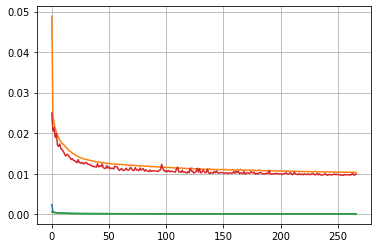

In [122]:
pred=[]
batch_size = 256
epoch = 500
verbose = 0
dropout_ratio = 0
with tf.device("/device:CPU:0"):
        
        # Parameters
        scaler_X_tr = preprocessing.MinMaxScaler(feature_range=(-1,1))
        scaler_Y_tr = preprocessing.MinMaxScaler(feature_range=(-1,1))
        
        ## Scaling
        x_train = scaler_X_tr.fit_transform(X_train)
        x_valid = scaler_X_tr.transform(X_valid)
        y_train = scaler_Y_tr.fit_transform(Y_train)
        y_valid = scaler_Y_tr.transform(Y_valid)
        
        seed_scaled = scaler_X_tr.transform(X_test)
        earlystopping = EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss) 
                                         patience=25
                                        ,verbose=0, restore_best_weights=True) # 25회 Epoch동안 개선되지 않는다면 종료
        
        # MLP
        inputs = Input(shape=(X_train.shape[1],))
        Selection = Dense(X_train.shape[1], activation='sigmoid')(inputs)
        Selection = Model(inputs=inputs, outputs=Selection)
        Extraction = Dense(X_train.shape[1], activation='tanh')(inputs)
        Extraction = Model(inputs=inputs, outputs=Extraction)
        x_multiply = Multiply()([inputs,Selection.output])
        Added = Add()([x_multiply, Extraction.output])
        hidden1 = Dense(512, activation='elu')(Added)
        hidden2 = Dense(512, activation='elu')(hidden1)
        hidden3 = Dense(512, activation='elu')(hidden2)
        hidden4 = Dense(512, activation='elu')(hidden3)
        out = Dense(4,activation='linear')(hidden4)
        model = Model(inputs=inputs, outputs=out)
        model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics = tf.keras.metrics.RootMeanSquaredError())
        model.summary()
        model_fit = model.fit(x_train, y_train,
                                  batch_size=batch_size, 
                                  epochs=epoch, 
                                validation_data=(x_valid,y_valid),callbacks=[ earlystopping],
                                  verbose=1)

        
        plt.plot(pd.DataFrame(model_fit.history))
        plt.grid(True)
        plt.show()
        model.save_weights('./For_CL.h5')

# Elastic Weight Consolidation(EWC) 사용

In [160]:
def inference(model, test_tasks):
    for xp in test_tasks[0]:
        preds = model.predict_on_batch(xp)
    return preds

class Train:
    
    def __init__(self, optimizer, loss_fn, prior_weights=None, lambda_=1):
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.prior_weights = prior_weights
        self.lambda_ = lambda_
        
    def train(self, model, epochs, train_task, fisher_matrix=None, test_tasks=None):
        # empty list to collect per epoch test mse of each task
        test_mse=[]
        for epoch in tqdm(range(epochs)):
            for batch in train_task:
                X,y = batch
                with tf.GradientTape() as tape:
                    pred = model(X)
                    loss = self.loss_fn(y, pred)
                    # if to execute training with EWC
                    if fisher_matrix is not None:
                        loss += self.compute_penalty_loss(model, fisher_matrix)
                grads = tape.gradient(loss, model.trainable_variables)
                self.optimizer.apply_gradients(zip(grads, model.trainable_variables))
            # evaluate with the test set of task after each epoch
            for xp in test_tasks:
                preds = model.predict_on_batch([xp])
                test_mse.append(preds)
        
        return test_mse

    def compute_penalty_loss(self, model, fisher_matrix):
        penalty = 0.
        for u, v, w in zip(fisher_matrix, model.weights, self.prior_weights):
            penalty += tf.math.reduce_sum(u * tf.math.square(v - w))
        return 0.5 * self.lambda_ * penalty
    

class EWC:
    
    def __init__(self, prior_model, data_samples, num_sample=100000):
        self.prior_model = prior_model
        self.prior_weights = prior_model.weights
        self.num_sample = num_sample
        self.data_samples = data_samples
        self.fisher_matrix = self.compute_fisher()
        
    def compute_fisher(self):
        weights = self.prior_weights
        fisher_mseum = np.array([np.zeros(layer.numpy().shape) for layer in weights], 
                           dtype=object
                          )
        for j in tqdm(range(self.num_sample)):
            idx = np.random.randint(self.data_samples.shape[0])
            with tf.GradientTape() as tape:
                logits = tf.nn.log_softmax(self.prior_model(np.array([self.data_samples[idx]])))
            grads = tape.gradient(logits, weights)
            for m in range(len(weights)):
                fisher_mseum[m] += np.square(grads[m])
        fisher_mseum /= self.num_sample
        return fisher_mseum
    
    def get_fisher(self):
        return self.fisher_matrix
    

class MLP3:
    
    def __init__(self, input_shape=(145,), hidden_layers_neuron_list=[128, 256,256], num_classes=4):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.hidden_layers_neuron_list = hidden_layers_neuron_list
        self.model = self.create_mlp()
        
    def create_mlp(self):
        inputs = Input(self.input_shape)
        Selection = Dense(self.input_shape[0], activation='sigmoid')(inputs)
        Selection = Model(inputs=inputs, outputs=Selection)
        Extraction = Dense(self.input_shape[0], activation='tanh')(inputs)
        Extraction = Model(inputs=inputs, outputs=Extraction)
        x_multiply = Multiply()([inputs,Selection.output])
        Added = Add()([x_multiply, Extraction.output])
        hidden1 = Dense(512, activation='elu')(Added)
        hidden2 = Dense(512, activation='elu')(hidden1)
        hidden3 = Dense(512, activation='elu')(hidden2)
        hidden4 = Dense(512, activation='elu')(hidden3)
        out = Dense(4,activation='linear')(hidden4)
        model = Model(inputs=inputs, outputs=out)
        return model
    
    def get_uncompiled_model(self):
        return self.model
    
    def get_compiled_model(self, optimizer, loss_fn, metrics ):
        compiled_model = self.model
        compiled_model.compile(optimizer, loss_fn, metrics)
        return compiled_model

In [173]:
# 추론에 필요 없는 2022-07-18 23:50:00값 빼주기
data = data.iloc[:-1]

In [176]:
# 파라미터 세팅
mlp = MLP3()
epochs = 30
lr = 0.0001
num_sample = 10000
verbose=1
opt = tf.keras.optimizers.Adam(learning_rate=lr)
loss_fn=tf.keras.losses.MeanSquaredError()

In [177]:
# Parameters
scaler_X_tr = preprocessing.MinMaxScaler(feature_range=(-1,1))
scaler_Y_tr = preprocessing.MinMaxScaler(feature_range=(-1,1))

## Scaling
x_train = scaler_X_tr.fit_transform(X_train)
y_train = scaler_Y_tr.fit_transform(Y_train)
x_test = scaler_X_tr.transform(X_test)
y_test = scaler_Y_tr.transform(Y_test)

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [180]:
# Fisher Matrix 구하기, num_sample은 휴리스틱하게 10000으로 설정
with tf.device("/device:CPU:0"):
    model = mlp.get_compiled_model(opt, loss_fn, [tf.keras.metrics.RootMeanSquaredError()])
    ewc = EWC(model, x_train, num_sample=10000)
    f_matrix = ewc.get_fisher()

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:43<00:00, 96.57it/s]


# Inference(주석 지우고 실행)

In [235]:
#predic=[]
#with tf.device("/device:CPU:0"):
#    X = data.drop(['청담대교_10Min','잠수교_10Min','한강대교_10Min','행주대교_10Min'],axis=1)
#    y = data[['청담대교_10Min','잠수교_10Min','한강대교_10Min','행주대교_10Min']]
#    lam=55000
#    for i in tqdm(range(0,192)):
#        if i==0:
#            model_ewcB = mlp.get_compiled_model(opt, loss_fn, [tf.keras.metrics.RootMeanSquaredError()])
#            model_ewcB.load_weights('For_CL.h5')
#            pred = model_ewcB.predict(x_test[:36])
#            predic.append(scaler_Y_tr.inverse_transform(pred))
#        else:
#            ## 학습데이터가 추가될 때마다 Scaling 새로 적용
#            x_train_re= scaler_X_tr.fit_transform(X.iloc[:-6912+36*(i)])
#            y_train_re= scaler_Y_tr.fit_transform(y.iloc[:-6912+36*(i)])
#            x_test_re= scaler_X_tr.transform(X.iloc[-6912+36*(i):])
#                        
#            x_train_s = x_train_re[-36*i:]
#            y_train_s = y_train_re[-36*i:]
#            x_test_s = x_test_re[:36]
#            
#            # Prior Weight load
#            model_ewc = mlp.get_compiled_model(opt, loss_fn, [tf.keras.metrics.RootMeanSquaredError()])
#            model_ewc.load_weights('For_CL.h5')
#            prior_weights = model_ewc.get_weights()
#            
#            train_B = tf.data.Dataset.from_tensor_slices((x_train_s, y_train_s)).batch(36)
#            test_B = x_test_s
#            trn = Train(opt, loss_fn, prior_weights=prior_weights, lambda_=lam)
#            pred= trn.train(model_ewc, 
#                                 267,    #Base Model의 Epoch과 같은 267로 설정
#                                 train_B, 
#                                 fisher_matrix=f_matrix, 
#                                 test_tasks=[test_B])        
#            predic.append(scaler_Y_tr.inverse_transform(pred[-1]))

In [240]:
#predic = np.array(predic).reshape(6912,4)
#
#conclude =pd.DataFrame(predic)

# 잔차 더하기(주석 지우고 실행)

In [238]:
#summission = pd.read_csv('./competition_data/sample_submission.csv')
#
#predictions_diff = pd.Series(conclude[0].values,index=summission.index)
#
#predictions_log = pd.Series(test['청담대교수위'].iloc[:-1].values,index=summission.index) # Series of base number
#
#predictions_lo = predictions_log.add(-predictions_diff)

In [237]:
#predictions_diff = pd.Series(conclude[1].values,index=summission.index)
#
#predictions_log = pd.Series(test['잠수교수위'].iloc[:-1].values,index=summission.index) # Series of base number
#
#predictions_lo1 = predictions_log.add(-predictions_diff)

In [236]:
#predictions_diff = pd.Series(conclude[2].values,index=summission.index)
#
#predictions_log = pd.Series(test['한강대교수위'].iloc[:-1].values,index=summission.index) # Series of base number
#
#predictions_lo2 = predictions_log.add(-predictions_diff)

In [239]:
#predictions_diff = pd.Series(conclude[3].values,index=summission.index)
#
#predictions_log = pd.Series(test['행주대교수위'].iloc[:-1].values,index=summission.index) # Series of base number
#
#predictions_lo3 = predictions_log.add(-predictions_diff)
#
#final = pd.concat([predictions_lo,predictions_lo1,predictions_lo2,predictions_lo3],axis=1)

In [241]:
# 최종제출
#summission.iloc[:,1:] = final.values
#
#summission.to_csv('./최종제출.csv',index=False)